In [380]:

import pandas as pd
import numpy as np
import copy
import sys
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_rows', 100)
sys.path.append("/Users/peterpriestley/hmf/repos/scripts/analysisscripts") 
import chromosomeDefinition as cd
import analyseVCF as aVCF


In [ ]:
# BED
BED_PATH = "/Users/peterpriestley/hmf/analyses/slices/"
BED_FILE_NAME = "cosmicCancerCensus.bed" 
#BED_FILE_NAME = "CPCT_Slicing.bed"
bed = aVCF.loadBEDFile(BED_PATH,BED_FILE_NAME)

In [488]:
CSV_PATH="/Users/peterpriestley/hmf/analyses/ensembleRuleTesting/"
CSV_FILENAME="CPCT02160002T_dedup.realigned.bam_CNVs"
COLS = ['chrom','posStart','posEnd','copyNum','gainOrLoss']
dfCNV = pd.read_table(CSV_PATH + CSV_FILENAME, names = COLS )

In [489]:
#add regions with default copy number
last = dfCNV.iloc[0]
for i in range(1, dfCNV.shape[0]-1):
    if last['posEnd']<>dfCNV.iloc[i]['posStart']:
        if last['chrom']==dfCNV.iloc[i]['chrom']:
            dfCNV.loc[len(dfCNV)] = [last['chrom'],last['posEnd'], dfCNV.iloc[i]['posStart']-1,2,'none']
        else:
            dfCNV.loc[len(dfCNV)] = [last['chrom'],last['posEnd'], cd.chromosomeLength[last['chrom']],2,'none']
            if dfCNV.iloc[i]['posStart']<>0:
                dfCNV.loc[len(dfCNV)] = [dfCNV.iloc[i]['chrom'],0, dfCNV.iloc[i]['posStart'],2,'none']
    last = dfCNV.iloc[i]
#fix first record
if dfCNV.iloc[0]['posStart']<>0:
    dfCNV.loc[len(dfCNV)] = ['1',0, dfCNV.iloc[0]['posStart'],2,'none']
#Additional Fields
dfCNV['chromPos']= dfCNV['chrom'].apply(lambda x: cd.intChrom(x)) + dfCNV['posStart'] / dfCNV['chrom'].apply(lambda x: cd.chromosomeLength[x])
dfCNV['chrom'] = dfCNV['chrom'].apply(lambda x: cd.intChrom(x))
dfCNV['cappedCopyNum'] = dfCNV['copyNum'].clip(upper=5)
dfCNV = dfCNV.sort_values(["chrom","posStart","posEnd"]).reset_index()
dfCNV['regionLength'] = (dfCNV['posEnd']-dfCNV['posStart'])/1e6

[1, 25, 0, 20]

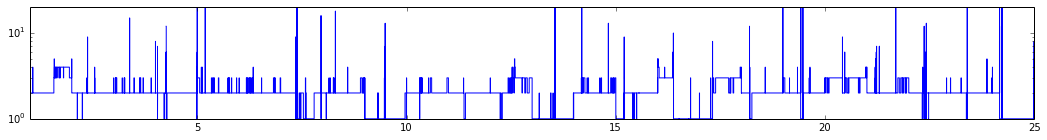

In [490]:
fig = plt.figure(figsize=[18,2])
ax = plt.gca()
ax.plot(dfCNV['chromPos'], dfCNV['copyNum'],drawstyle="steps-post")
ax.set_yscale('log')
ax.axis([1, 25, 0, 20])

In [491]:
dfCNV[['gainOrLoss','regionLength']].groupby(['gainOrLoss']).agg('sum')

,regionLength
gainOrLoss,
gain,417.594559
loss,485.330566
none,2192.752128


### Bed Analysis

In [494]:
bedDict ={}
for bedrow in bed:
    bedChromPosStart = cd.intChrom(bedrow[0]) + float(bedrow[1])/cd.chromosomeLength[bedrow[0]]
    bedChromPosEnd = cd.intChrom(bedrow[0]) + float(bedrow[1])/cd.chromosomeLength[bedrow[0]]
    prevCNV = max(dfCNV[(dfCNV['chromPos'] < bedChromPosStart)].index.tolist())
    nextCNV = min(dfCNV[(dfCNV['chromPos'] > bedChromPosEnd) ].index.tolist())
    for i in range (prevCNV,nextCNV):
        minCopyNum = min(([dfCNV.iloc[x]['copyNum']]) for x in range (prevCNV,nextCNV)) #[dfCNV.iloc[i]['copyNum']]
    if minCopyNum[0] <1:
        bedDict[bedrow[3]]=minCopyNum[0]#,bedChromPosStart,bedChromPosEnd]
print "count=", len(bedDict)
for key,value in bedDict.items():
    print key, value


count= 1
CBFB 0


In [493]:
for bedrow in bed:
    if bedrow[3]=='ERBB2':
        print bedrow

['17', '37856492', '37884297', 'ERBB2']


In [468]:
dfCNV[dfCNV.chrom==17]

,index,chrom,posStart,posEnd,copyNum,gainOrLoss,chromPos,cappedCopyNum,regionLength
607,414,17,0,5543000,3,gain,17.000000,3,5.543000
608,817,17,5543000,16655999,2,none,17.068268,2,11.112999
609,415,17,16656000,16748000,3,gain,17.205135,3,0.092000
610,818,17,16748000,18346999,2,none,17.206268,2,1.598999
611,416,17,18347000,18465000,1,loss,17.225962,1,0.118000
612,819,17,18465000,18506999,2,none,17.227415,2,0.041999
613,417,17,18507000,18521000,7,gain,17.227932,5,0.014000
614,820,17,18521000,20766999,2,none,17.228105,2,2.245999
615,418,17,20767000,20780000,5,gain,17.255766,5,0.013000
616,821,17,20780000,21193999,2,none,17.255926,2,0.413999
